In [170]:

#importy koniecznych bibliotek
import pandas as pd
import boto3
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from pycaret.regression import *


In [171]:
#ładowanie zmiennych, klucze do łączenia się z bucket w DigitalOcean
load_dotenv()

True

Umieszczenie danych w Digital Ocean Spaces.

In [172]:
#tworzenie klienta s3 do kontaktu z chmurą
s3= boto3.client("s3")

In [173]:
#nazwa bucketu w chmurze
BUCKET_NAME="halfmarathontime"

In [174]:
#przesłanie plików półmaraton 2023 i 2024 do bucketu w chmurze

s3.upload_file(
    Filename='halfmarathon_wroclaw_2023__final.csv',
    Bucket=BUCKET_NAME,
    Key='stocks/year=2023/halfmarathon_wroclaw_2023__final.csv'
)

s3.upload_file(
    Filename= 'halfmarathon_wroclaw_2024__final.csv',
    Bucket=BUCKET_NAME,
    Key='stocks/year=2024/halfmarathon_wroclaw_2024__final.csv'
)
print(f"Pliki zostały wysłane do Cloud Storage")

Pliki zostały wysłane do Cloud Storage


Wczytanie danych z Digital Ocean Spaces. 

In [175]:
#pobrane pliki zostana zapisane w folderze Dane
os.makedirs("Dane", exist_ok=True)
s3.download_file(BUCKET_NAME,"stocks/year=2023/halfmarathon_wroclaw_2023__final.csv", "Dane/halfmarathon_2023.csv")
print(f"Plik zostały pobrany i zapisany.")

Plik zostały pobrany i zapisany.


In [177]:
s3.download_file(BUCKET_NAME, "stocks/year=2024/halfmarathon_wroclaw_2024__final.csv", "Dane/halfmarathon_2024.csv")
print(f"Plik zostały pobrany i zapisany.")

Plik zostały pobrany i zapisany.


EDA i czyszczenie danych. 

In [178]:
#łączenie danych
file_2023 = "Dane/halfmarathon_2023.csv"
file_2024 = "Dane/halfmarathon_2024.csv"

df_2023 = pd.read_csv(file_2023, sep=";")
df_2024 = pd.read_csv(file_2024, sep=";")

#Połączenie DataFrame'ów w jeden
df_full = pd.concat([df_2023, df_2024], ignore_index=True)

In [179]:
df_full.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654


In [180]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21957 entries, 0 to 21956
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Miejsce                    18450 non-null  float64
 1   Numer startowy             21957 non-null  int64  
 2   Imię                       21957 non-null  object 
 3   Nazwisko                   21957 non-null  object 
 4   Miasto                     17774 non-null  object 
 5   Kraj                       18450 non-null  object 
 6   Drużyna                    8402 non-null   object 
 7   Płeć                       21946 non-null  object 
 8   Płeć Miejsce               18450 non-null  float64
 9   Kategoria wiekowa          21926 non-null  object 
 10  Kategoria wiekowa Miejsce  18430 non-null  float64
 11  Rocznik                    21472 non-null  float64
 12  5 km Czas                  18411 non-null  object 
 13  5 km Miejsce Open          18411 non-null  flo

In [181]:
# Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [182]:
df_full['Czas'] = df_full['Czas'].apply(convert_time_to_seconds)

In [183]:
time_columns = [ '5 km Czas', '10 km Czas', '15 km Czas', '20 km Czas']
for col in time_columns:
    df_full[col] = df_full[col].apply(convert_time_to_seconds)

In [184]:
df_full.head()

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,2687.0,1.0,3.106667,3703.0,1.0,3.386667,0.031400,3899.0,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,2726.0,2.0,3.143333,3788.0,2.0,3.540000,0.038000,3983.0,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,2854.0,3.0,3.236667,3909.0,3.0,3.516667,0.024067,4104.0,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,2929.0,5.0,3.330000,4014.0,4.0,3.616667,0.025467,4216.0,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,2971.0,7.0,3.386667,4047.0,5.0,3.586667,0.023000,4227.0,3.339654


In [185]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21957 entries, 0 to 21956
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Miejsce                    18450 non-null  float64
 1   Numer startowy             21957 non-null  int64  
 2   Imię                       21957 non-null  object 
 3   Nazwisko                   21957 non-null  object 
 4   Miasto                     17774 non-null  object 
 5   Kraj                       18450 non-null  object 
 6   Drużyna                    8402 non-null   object 
 7   Płeć                       21946 non-null  object 
 8   Płeć Miejsce               18450 non-null  float64
 9   Kategoria wiekowa          21926 non-null  object 
 10  Kategoria wiekowa Miejsce  18430 non-null  float64
 11  Rocznik                    21472 non-null  float64
 12  5 km Czas                  18411 non-null  float64
 13  5 km Miejsce Open          18411 non-null  flo

In [186]:
#brakujace wartości
df_full.isnull().sum()

Miejsce                       3507
Numer startowy                   0
Imię                             0
Nazwisko                         0
Miasto                        4183
Kraj                          3507
Drużyna                      13555
Płeć                            11
Płeć Miejsce                  3507
Kategoria wiekowa               31
Kategoria wiekowa Miejsce     3527
Rocznik                        485
5 km Czas                     3546
5 km Miejsce Open             3546
5 km Tempo                    3546
10 km Czas                    3530
10 km Miejsce Open            3530
10 km Tempo                   3562
15 km Czas                    3529
15 km Miejsce Open            3529
15 km Tempo                   3544
20 km Czas                    3518
20 km Miejsce Open            3518
20 km Tempo                   3535
Tempo Stabilność              3580
Czas                          3507
Tempo                         3507
dtype: int64

In [187]:
# Usunięcie wierszy, gdzie brakuje wartości w kolumnie 'Czas'
df_cleaned = df_full.dropna(subset=['Czas'])

In [188]:
df_cleaned.isnull().sum()

Miejsce                          0
Numer startowy                   0
Imię                             0
Nazwisko                         0
Miasto                         676
Kraj                             0
Drużyna                      11302
Płeć                             0
Płeć Miejsce                     0
Kategoria wiekowa               20
Kategoria wiekowa Miejsce       20
Rocznik                        485
5 km Czas                       39
5 km Miejsce Open               39
5 km Tempo                      39
10 km Czas                      23
10 km Miejsce Open              23
10 km Tempo                     55
15 km Czas                      22
15 km Miejsce Open              22
15 km Tempo                     37
20 km Czas                      11
20 km Miejsce Open              11
20 km Tempo                     28
Tempo Stabilność                73
Czas                             0
Tempo                            0
dtype: int64

In [189]:
print("Procent pozostałych danych:", round((len(df_cleaned) / len(df_full)) * 100, 2), "%")

Procent pozostałych danych: 84.03 %


In [190]:
#dulikaty
df_cleaned[df_cleaned.duplicated()]

,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo


In [191]:
df_cleaned.columns

Index(['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj',
       'Drużyna', 'Płeć', 'Płeć Miejsce', 'Kategoria wiekowa',
       'Kategoria wiekowa Miejsce', 'Rocznik', '5 km Czas',
       '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open',
       '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo',
       '20 km Czas', '20 km Miejsce Open', '20 km Tempo', 'Tempo Stabilność',
       'Czas', 'Tempo'],
      dtype='object')

In [ ]:
# reset kolumn
df_cleaned = df_cleaned[['Płeć', 'Kategoria wiekowa','Rocznik', '5 km Czas', '5 km Tempo', '10 km Czas', '10 km Tempo',
        '15 km Czas', '15 km Tempo', '20 km Czas', '20 km Tempo', 'Czas', 'Tempo']].copy()

In [193]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18450 entries, 0 to 19249
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Płeć               18450 non-null  object 
 1   Kategoria wiekowa  18430 non-null  object 
 2   Rocznik            17965 non-null  float64
 3   5 km Czas          18411 non-null  float64
 4   5 km Tempo         18411 non-null  float64
 5   10 km Czas         18427 non-null  float64
 6   10 km Tempo        18395 non-null  float64
 7   15 km Czas         18428 non-null  float64
 8   15 km Tempo        18413 non-null  float64
 9   20 km Czas         18439 non-null  float64
 10  20 km Tempo        18422 non-null  float64
 11  Czas               18450 non-null  float64
 12  Tempo              18450 non-null  float64
dtypes: float64(11), object(2)
memory usage: 2.0+ MB


In [194]:

#zmiana kolumny Rocznik na Wiek
df_cleaned['Wiek'] = 2024 - df_cleaned['Rocznik']
df_cleaned = df_cleaned.drop(columns=['Rocznik'])

In [195]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18450 entries, 0 to 19249
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Płeć               18450 non-null  object 
 1   Kategoria wiekowa  18430 non-null  object 
 2   5 km Czas          18411 non-null  float64
 3   5 km Tempo         18411 non-null  float64
 4   10 km Czas         18427 non-null  float64
 5   10 km Tempo        18395 non-null  float64
 6   15 km Czas         18428 non-null  float64
 7   15 km Tempo        18413 non-null  float64
 8   20 km Czas         18439 non-null  float64
 9   20 km Tempo        18422 non-null  float64
 10  Czas               18450 non-null  float64
 11  Tempo              18450 non-null  float64
 12  Wiek               17965 non-null  float64
dtypes: float64(11), object(2)
memory usage: 2.0+ MB


In [196]:
df_cleaned.head()

,Płeć,Kategoria wiekowa,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Czas,Tempo,Wiek
0,M,M30,877.0,2.923333,1755.0,2.926667,2687.0,3.106667,3703.0,3.386667,3899.0,3.080509,32.0
1,M,M30,888.0,2.960000,1783.0,2.983333,2726.0,3.143333,3788.0,3.540000,3983.0,3.146875,38.0
2,M,M20,946.0,3.153333,1883.0,3.123333,2854.0,3.236667,3909.0,3.516667,4104.0,3.242475,28.0
3,M,M30,971.0,3.236667,1930.0,3.196667,2929.0,3.330000,4014.0,3.616667,4216.0,3.330963,36.0
4,M,M20,972.0,3.240000,1955.0,3.276667,2971.0,3.386667,4047.0,3.586667,4227.0,3.339654,29.0


In [197]:
df_cleaned.isnull().sum()

Płeć                   0
Kategoria wiekowa     20
5 km Czas             39
5 km Tempo            39
10 km Czas            23
10 km Tempo           55
15 km Czas            22
15 km Tempo           37
20 km Czas            11
20 km Tempo           28
Czas                   0
Tempo                  0
Wiek                 485
dtype: int64

In [198]:
# wartości brakujace w ujęciu procentowym

df_cleaned.isnull().sum() / len(df_cleaned) 

Płeć                 0.000000
Kategoria wiekowa    0.001084
5 km Czas            0.002114
5 km Tempo           0.002114
10 km Czas           0.001247
10 km Tempo          0.002981
15 km Czas           0.001192
15 km Tempo          0.002005
20 km Czas           0.000596
20 km Tempo          0.001518
Czas                 0.000000
Tempo                0.000000
Wiek                 0.026287
dtype: float64

In [199]:
#usunięcie brakujacych wartości w kolumnie Wiek
df_cleaned = df_cleaned.dropna(subset=["Wiek"])
df_cleaned.sample(5)

,Płeć,Kategoria wiekowa,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Czas,Tempo,Wiek
10255,M,M20,1544.0,5.146667,3011.0,4.890000,4450.0,4.796667,5818.0,4.560000,6126.0,4.840009,25.0
2545,M,M40,1494.0,4.980000,3019.0,5.083333,4621.0,5.340000,6361.0,5.800000,6681.0,5.278502,42.0
5426,K,K50,1793.0,5.976667,3565.0,5.906667,5402.0,6.123333,7378.0,6.586667,7735.0,6.111243,59.0
14132,M,M20,1766.0,5.886667,3499.0,5.776667,5239.0,5.800000,6964.0,5.750000,7318.0,5.781781,26.0
2289,M,M40,1521.0,5.070000,3021.0,5.000000,4559.0,5.126667,6256.0,5.656667,6589.0,5.205815,48.0


In [200]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17965 entries, 0 to 19248
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Płeć               17965 non-null  object 
 1   Kategoria wiekowa  17945 non-null  object 
 2   5 km Czas          17927 non-null  float64
 3   5 km Tempo         17927 non-null  float64
 4   10 km Czas         17944 non-null  float64
 5   10 km Tempo        17912 non-null  float64
 6   15 km Czas         17945 non-null  float64
 7   15 km Tempo        17931 non-null  float64
 8   20 km Czas         17955 non-null  float64
 9   20 km Tempo        17939 non-null  float64
 10  Czas               17965 non-null  float64
 11  Tempo              17965 non-null  float64
 12  Wiek               17965 non-null  float64
dtypes: float64(11), object(2)
memory usage: 1.9+ MB


In [201]:
df_cleaned.isnull().sum()

Płeć                  0
Kategoria wiekowa    20
5 km Czas            38
5 km Tempo           38
10 km Czas           21
10 km Tempo          53
15 km Czas           20
15 km Tempo          34
20 km Czas           10
20 km Tempo          26
Czas                  0
Tempo                 0
Wiek                  0
dtype: int64

In [202]:
#usunięcie null w Kategoria wiekowa
df_cleaned = df_cleaned.dropna(subset=["Kategoria wiekowa"])

In [203]:
print("Procent pozostałych danych:", round((len(df_cleaned) / len(df_full)) * 100, 2), "%")

Procent pozostałych danych: 81.73 %


<Axes: xlabel='5 km Tempo', ylabel='Czas'>

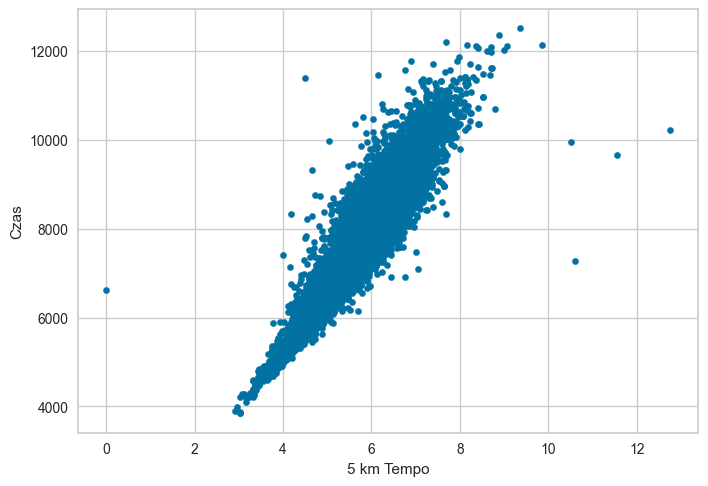

In [204]:
#wizualizacja kilku zależności
df_cleaned.plot(kind='scatter', x='5 km Tempo', y='Czas')

<Axes: xlabel='5 km Czas', ylabel='Czas'>

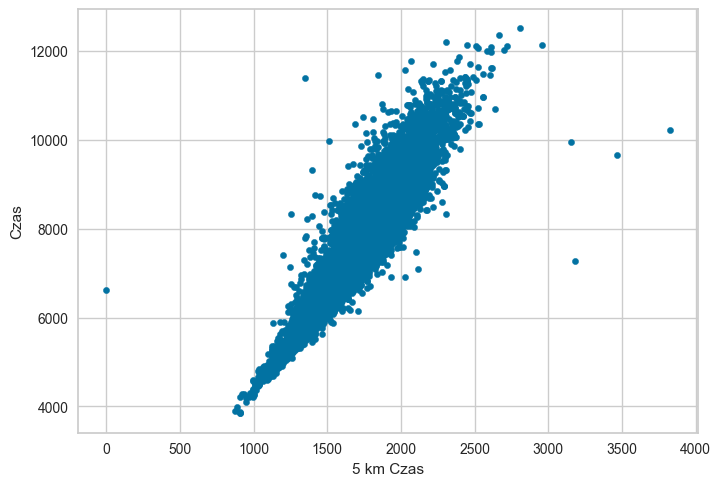

In [205]:
df_cleaned.plot(kind='scatter', x='5 km Czas', y='Czas')

<Axes: xlabel='Tempo', ylabel='Czas'>

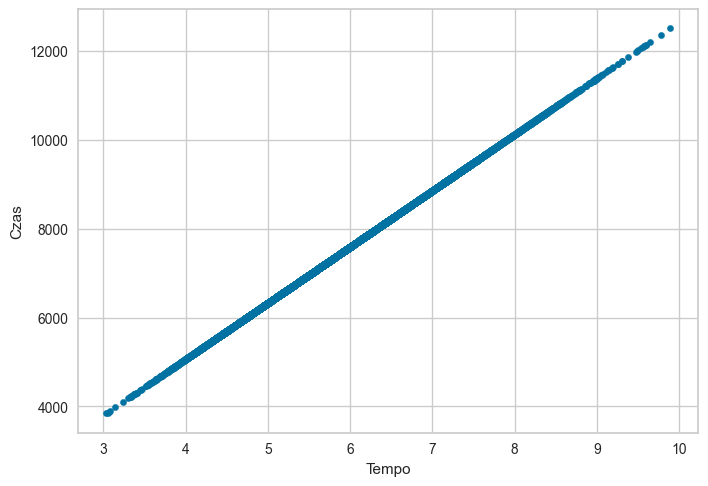

In [206]:
df_cleaned.plot(kind='scatter', x='Tempo', y='Czas')

<Axes: xlabel='Wiek', ylabel='Czas'>

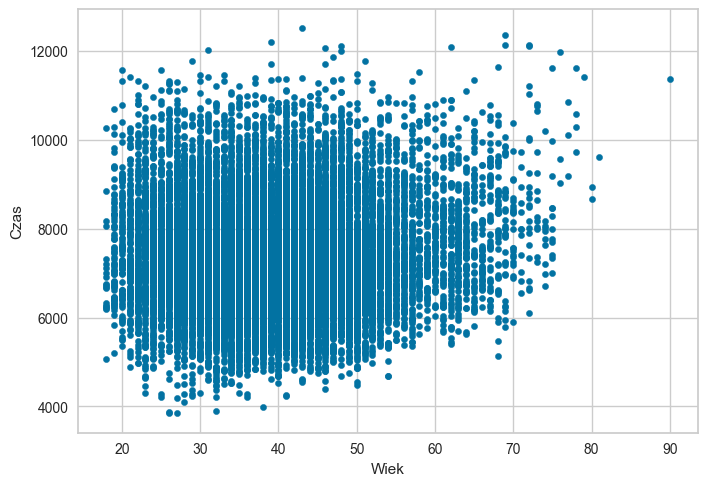

In [207]:
df_cleaned.plot(kind='scatter', x='Wiek', y='Czas')

array([[<Axes: title={'center': 'Czas'}>]], dtype=object)

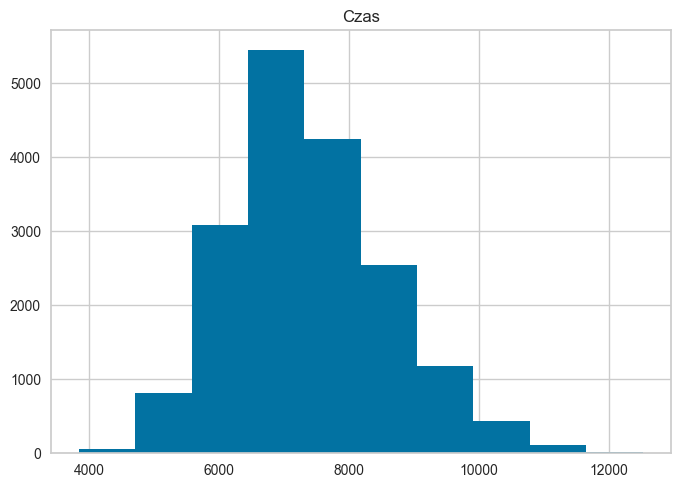

In [208]:
df_cleaned.hist('Czas')

array([[<Axes: title={'center': 'Wiek'}>]], dtype=object)

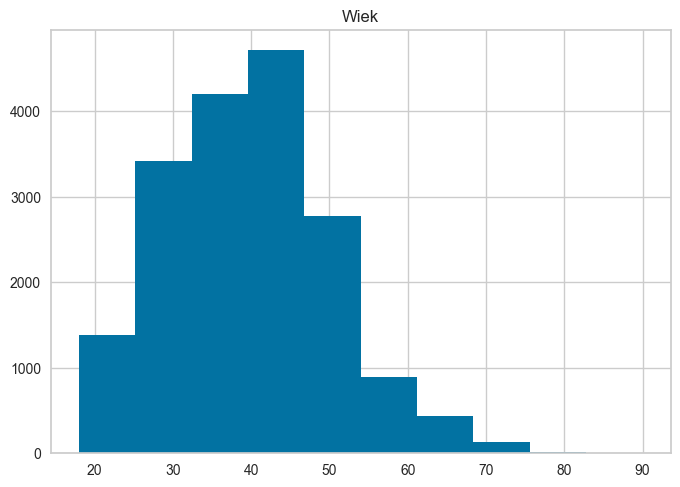

In [209]:
df_cleaned.hist('Wiek')

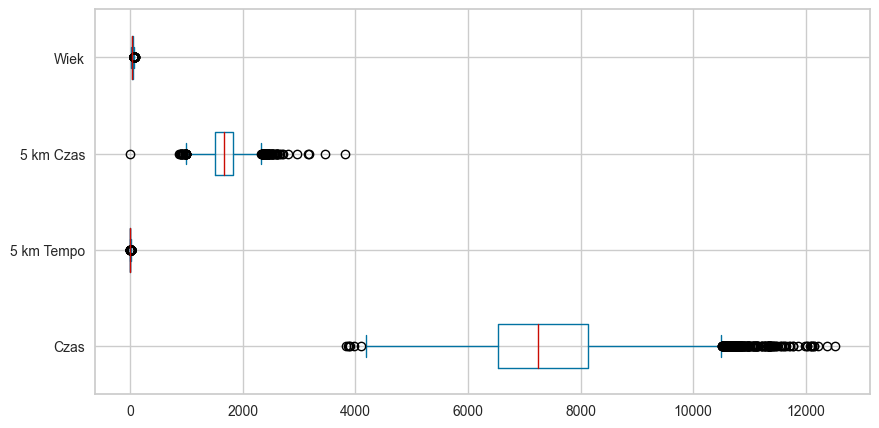

In [ ]:
#wartości odstajace

# Wykres pudełkowy dla kolumn 'Czas', '5 km Tempo' i '5 km Czas'
df_cleaned[['Czas', '5 km Tempo', '5 km Czas', 'Wiek']].plot(kind='box', vert=False, figsize=(10, 5), grid=True)
plt.show()


In [213]:

# Lista kolumn, w których usuwamu wartości odstające
columns_to_check = ["Czas", "5 km Tempo", "5 km Czas","Wiek"]


df_no_outliers = df_cleaned.copy()

for col in columns_to_check:
    Q1 = df_cleaned[col].quantile(0.25)  # 1. kwartyl (25%)
    Q3 = df_cleaned[col].quantile(0.75)  # 3. kwartyl (75%)
    IQR = Q3 - Q1  # Rozstęp międzykwartylowy

    # Ustalamy dolną i górną granicę (zwykle 1.5*IQR to standardowy próg)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Usuwamy wartości odstające dla kolumn
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

# Aktualizacja df_cleaned po usunięciu wartości odstających
df_cleaned = df_no_outliers.copy()

# Sprawdzenie, ile procent danych usunięto
print(f"Pozostało {round((len(df_cleaned) / len(df_full)) * 100, 2)}% danych.")


Pozostało 79.5% danych.


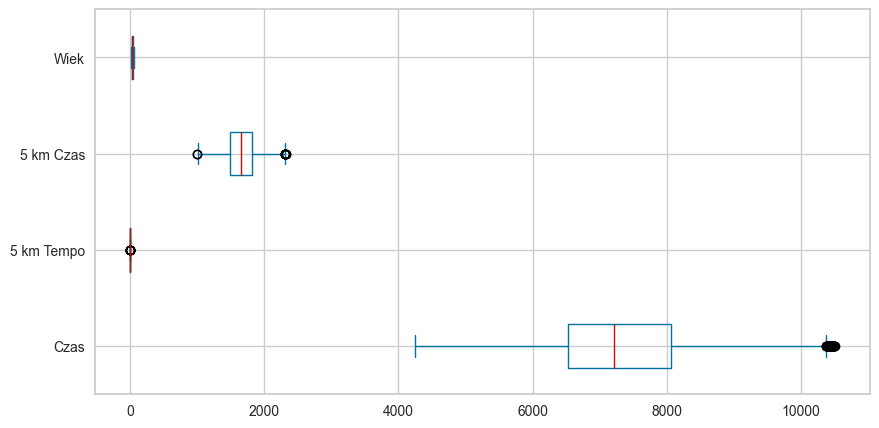

In [ ]:
df_cleaned[['Czas', '5 km Tempo', '5 km Czas', 'Wiek']].plot(kind='box', vert=False, figsize=(10, 5), grid=True)

plt.show()

In [215]:
df_cleaned.isnull().sum()

Płeć                  0
Kategoria wiekowa     0
5 km Czas             0
5 km Tempo            0
10 km Czas           12
10 km Tempo          12
15 km Czas           10
15 km Tempo          21
20 km Czas            6
20 km Tempo          16
Czas                  0
Tempo                 0
Wiek                  0
dtype: int64

In [217]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17455 entries, 8 to 19096
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Płeć               17455 non-null  object 
 1   Kategoria wiekowa  17455 non-null  object 
 2   5 km Czas          17455 non-null  float64
 3   5 km Tempo         17455 non-null  float64
 4   10 km Czas         17443 non-null  float64
 5   10 km Tempo        17443 non-null  float64
 6   15 km Czas         17445 non-null  float64
 7   15 km Tempo        17434 non-null  float64
 8   20 km Czas         17449 non-null  float64
 9   20 km Tempo        17439 non-null  float64
 10  Czas               17455 non-null  float64
 11  Tempo              17455 non-null  float64
 12  Wiek               17455 non-null  float64
dtypes: float64(11), object(2)
memory usage: 1.9+ MB


In [218]:
df_cleaned.tail(6)

,Płeć,Kategoria wiekowa,5 km Czas,5 km Tempo,10 km Czas,10 km Tempo,15 km Czas,15 km Tempo,20 km Czas,20 km Tempo,Czas,Tempo,Wiek
19091,M,M30,1812.0,6.040000,4238.0,8.086667,6987.0,9.163333,9896.0,9.696667,10483.0,8.282373,36.0
19092,K,K20,2139.0,7.130000,4463.0,7.746667,7141.0,8.926667,9932.0,9.303333,10483.0,8.282373,26.0
19093,M,M50,2197.0,7.323333,4434.0,7.456667,6778.0,7.813333,9705.0,9.756667,10486.0,8.284744,54.0
19094,M,M20,2197.0,7.323333,4433.0,7.453333,6778.0,7.816667,9705.0,9.756667,10486.0,8.284744,29.0
19095,K,K30,2206.0,7.353333,4486.0,7.600000,7047.0,8.536667,9869.0,9.406667,10492.0,8.289484,39.0
19096,M,M40,2269.0,7.563333,4537.0,7.560000,7074.0,8.456667,9867.0,9.310000,10500.0,8.295805,43.0


In [219]:
#zapisanie df z wyczyszczonymi danymi
df_cleaned.to_csv("df_cleaned.csv", index=False)

Trenowanie modelu.

In [220]:
#przygotowanie exp i określenie potrzebnych cech
exp = setup(
    data=df_cleaned, 
    target='Czas',
    categorical_features=['Płeć'], 
    ignore_features=['Kategoria wiekowa','10 km Czas', '10 km Tempo','15 km Czas', '15 km Tempo',
                     '20 km Tempo','Tempo', '20 km Czas'],
    session_id=123,
)

,Description,Value
0,Session id,123
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17455, 13)"
4,Transformed data shape,"(17455, 5)"
5,Transformed train set shape,"(12218, 5)"
6,Transformed test set shape,"(5237, 5)"
7,Ignore features,8
8,Numeric features,3
9,Categorical features,1


In [221]:
#dane po uruchomieniu trenowania
exp.dataset_transformed

,Płeć,5 km Czas,5 km Tempo,Wiek,Czas
2067,1.0,1425.0,4.750000,39.0,6515.0
6115,0.0,1864.0,6.213333,30.0,8073.0
3438,0.0,1655.0,5.516667,30.0,7011.0
5591,0.0,1840.0,6.133333,61.0,7809.0
9432,1.0,1275.0,4.250000,21.0,5614.0
...,...,...,...,...,...
15748,0.0,1806.0,6.020000,46.0,7845.0
12980,1.0,1708.0,5.693333,27.0,7032.0
99,1.0,1155.0,3.850000,42.0,5025.0
14009,1.0,1473.0,4.910000,21.0,7276.0


In [222]:
#szukanie najlepszego modelu, MAE metryka, która mierzy średni błąd bezwzględny, (niskie wartości oczekiwane)
best_model = exp.compare_models(sort='MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,286.9315,161060.9053,401.1698,0.8744,0.0513,0.0376,0.0430
gbr,Gradient Boosting Regressor,290.7292,157064.0996,396.1786,0.8774,0.0510,0.0384,0.2230
lasso,Lasso Regression,290.8878,157199.9200,396.3508,0.8774,0.0510,0.0384,0.0230
llar,Lasso Least Angle Regression,290.8878,157199.9200,396.3508,0.8774,0.0510,0.0384,0.0230
en,Elastic Net,290.8886,157200.1795,396.3511,0.8774,0.0510,0.0384,0.0220
br,Bayesian Ridge,290.8909,157201.3246,396.3526,0.8774,0.0510,0.0384,0.0240
ridge,Ridge Regression,290.9139,157216.9656,396.3726,0.8774,0.0510,0.0384,0.0240
lar,Least Angle Regression,290.9592,157253.0383,396.4176,0.8773,0.0510,0.0384,0.0220
lr,Linear Regression,290.9638,157254.9016,396.4200,0.8773,0.0510,0.0384,0.7330
omp,Orthogonal Matching Pursuit,291.1156,157384.4278,396.5791,0.8772,0.0510,0.0385,0.0220


In [223]:
metryki_przed_tuningiem = pull()
metryki_przed_tuningiem

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,286.9315,1.610609e+05,401.1698,0.8744,0.0513,0.0376,0.043
gbr,Gradient Boosting Regressor,290.7292,1.570641e+05,396.1786,0.8774,0.0510,0.0384,0.223
lasso,Lasso Regression,290.8878,1.571999e+05,396.3508,0.8774,0.0510,0.0384,0.023
llar,Lasso Least Angle Regression,290.8878,1.571999e+05,396.3508,0.8774,0.0510,0.0384,0.023
en,Elastic Net,290.8886,1.572002e+05,396.3511,0.8774,0.0510,0.0384,0.022
br,Bayesian Ridge,290.8909,1.572013e+05,396.3526,0.8774,0.0510,0.0384,0.024
ridge,Ridge Regression,290.9139,1.572170e+05,396.3726,0.8774,0.0510,0.0384,0.024
lar,Least Angle Regression,290.9592,1.572530e+05,396.4176,0.8773,0.0510,0.0384,0.022
lr,Linear Regression,290.9638,1.572549e+05,396.4200,0.8773,0.0510,0.0384,0.733
omp,Orthogonal Matching Pursuit,291.1156,1.573844e+05,396.5791,0.8772,0.0510,0.0385,0.022


In [224]:
# próba strojenia hiperparametrów, tuning

best_tuned_model = exp.tune_model(best_model, n_iter=200, optimize='MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,280.7708,157762.6961,397.1935,0.8760,0.0511,0.0368
1,283.0974,162004.1153,402.4973,0.8659,0.0518,0.0373
2,277.7316,147825.1865,384.4804,0.8740,0.0501,0.0368
3,288.9375,167178.1554,408.8743,0.8682,0.0521,0.0375
4,288.6995,175513.7537,418.9436,0.8717,0.0538,0.0377
5,281.5382,156550.2474,395.6643,0.8809,0.0508,0.0368
6,303.8076,180054.6180,424.3284,0.8639,0.0531,0.0390
7,281.0970,157039.4253,396.2820,0.8785,0.0508,0.0368
8,293.7725,165074.7369,406.2939,0.8755,0.0516,0.0383


Fitting 10 folds for each of 200 candidates, totalling 2000 fits


In [225]:
#porównanie
best_final_model = compare_models([best_model, best_tuned_model])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Huber Regressor,286.9315,161060.9053,401.1698,0.8744,0.0513,0.0376,0.0490
1,Huber Regressor,286.1833,162654.9025,403.1479,0.8732,0.0516,0.0374,0.0440


In [226]:
#uruchomienie modelu na holdout set
exp.predict_model(best_final_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,292.9231,165010.7699,406.2152,0.8725,0.0518,0.0383


,Płeć,5 km Czas,5 km Tempo,Wiek,Czas,prediction_label
3337,K,1615.0,5.383333,33.0,6979.0,7091.023907
14159,K,1657.0,5.523334,38.0,7326.0,7278.031932
3366,M,1595.0,5.316667,42.0,6988.0,6984.553911
17884,M,1957.0,6.523334,57.0,8845.0,8580.359076
12078,K,1588.0,5.293334,40.0,6791.0,6976.630831
...,...,...,...,...,...,...
15748,K,1806.0,6.020000,46.0,7845.0,7935.910421
12980,M,1708.0,5.693333,27.0,7032.0,7471.464920
99,M,1155.0,3.850000,42.0,5025.0,5055.301034
14009,M,1473.0,4.910000,21.0,7276.0,6437.646014


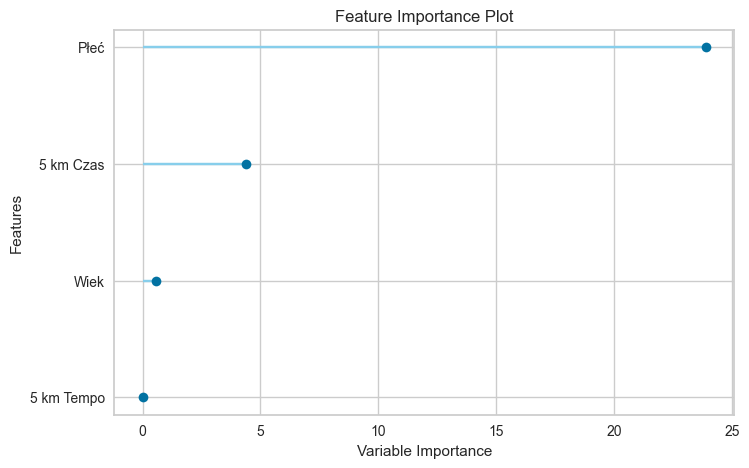

In [227]:
# wizualizacja istotności cech

plot_model(best_final_model, plot='feature')

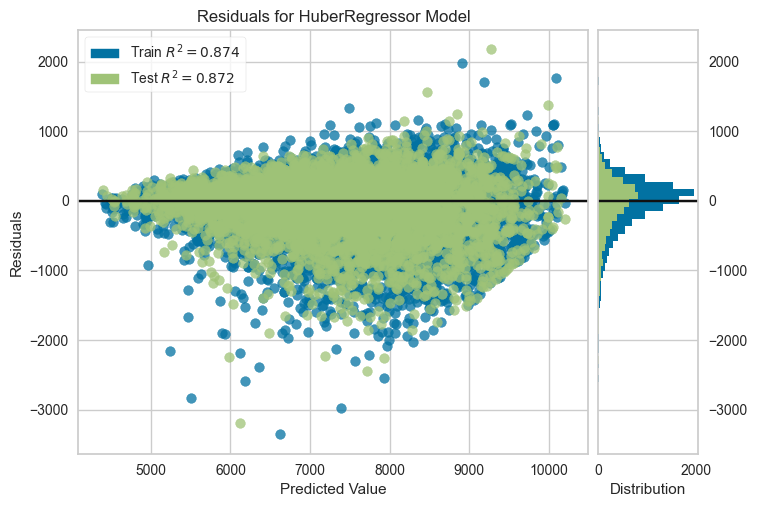

In [228]:
plot_model(best_final_model, plot="residuals")

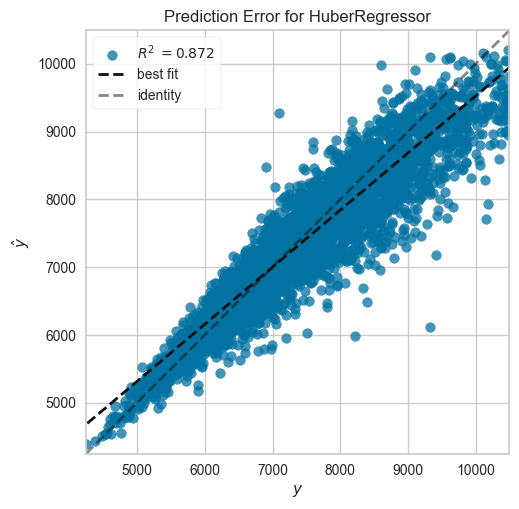

In [ ]:

#jak model sie myli
plot_model(best_final_model, plot='error')

In [230]:
# trenuję model na całym Dataset

final_model = finalize_model(best_final_model)

In [231]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['5 km Czas', '5 km Tempo', 'Wiek'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['Płeć'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('ordinal_encoding',
                 TransformerWrapper(include=['Płeć'],
                                    transformer=OrdinalEncoder(cols=['Płeć'],
                                                               handle_missing='return_nan',
                                                               mapping=[{'col': 'Płeć',
                                                                         'data_type': dtype('O'),
                                                                         'mapping': K      0
M      1
NaN   -1
dtype: int64}]))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator', HuberRegressor())])

Zapisywanie modelu.

In [232]:
save_model(final_model, 'huber_model_halfmarathon_time')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['5 km Czas', '5 km Tempo', 'Wiek'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}])

In [ ]:
# zapisanie modelu w Spaces Object Storage

s3.upload_file(
    Filename="huber_model_halfmarathon_time.pkl",
    Bucket=BUCKET_NAME,
    Key='stocks/model/huber_model_halfmarathon_time.pkl'
)

Próba działania modelu.

In [233]:
user_data_df = pd.DataFrame(
        {'Wiek' : 28,
        'Płeć' : 'M',
        '5 km Tempo' : 4.45, 
        '5 km Czas' : 1500,
        }, index=[0])

In [234]:
import datetime

prediction = predict_model(final_model, data=user_data_df)

prediction_seconds = round(prediction["prediction_label"][0], 2)

prediction_time = str(datetime.timedelta(seconds=int(prediction_seconds)))

print(f'Próba modelu, przewidywanie czas ukończenia półmaratonu: H:M:S wynosi {prediction_time}')

Próba modelu, przewidywanie czas ukończenia półmaratonu: H:M:S wynosi 1:49:20


In [235]:
user_1_data_df = pd.DataFrame(
        {'Wiek' : 32,
        'Płeć' : 'K',
        '5 km Tempo' : 6.45, 
        '5 km Czas' : 2100,
        }, index=[0])

In [236]:
prediction = predict_model(final_model, data=user_1_data_df)

prediction_seconds = round(prediction["prediction_label"][0], 2)

prediction_time = str(datetime.timedelta(seconds=int(prediction_seconds)))

print(f'Próba modelu, przewidywanie czas ukończenia półmaratonu: H:M:S wynosi {prediction_time}')

Próba modelu, przewidywanie czas ukończenia półmaratonu: H:M:S wynosi 2:33:36


In [238]:
user_2_data_df = pd.DataFrame(
        {'Wiek' : 53,
        'Płeć' : 'M',
        '5 km Tempo' : 5.45, 
        '5 km Czas' : 1900,
        }, index=[0])

In [239]:

prediction = predict_model(final_model, data=user_2_data_df)

# Pobranie przewidywanej wartości i zaokrąglenie
predicted_seconds = round(prediction["prediction_label"].iloc[0], 2)

# Konwersja sekund na format godzinowy (H:M:S)
predicted_time = str(datetime.timedelta(seconds=int(predicted_seconds)))


print(f"Przewidywany czas ukończenia półmaratonu: {predicted_time}")


Przewidywany czas ukończenia półmaratonu: 2:18:50


In [2]:
import pandas as pd
df_spr= pd.read_csv("df_cleaned.csv")


In [9]:
print(df_spr["5 km Tempo"].describe())

count    17455.000000
mean         5.541164
std          0.775363
min          3.340000
25%          4.990000
50%          5.513333
75%          6.070000
max          7.760000
Name: 5 km Tempo, dtype: float64


In [11]:
print(df_spr["5 km Czas"].describe())

count    17455.000000
mean      1662.349184
std        232.608990
min       1002.000000
25%       1497.000000
50%       1654.000000
75%       1821.000000
max       2328.000000
Name: 5 km Czas, dtype: float64
